From here until the Histogram is basically loading in data and EDA. From the Histogram down is the real modeling work.

In [8]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor, export_text


In [9]:
offers = pd.read_csv("starbucks_data/portfolio.csv")
offers.head(10)

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [10]:
offers[offers["offer_type"] == "bogo"]

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


In [11]:
customers = pd.read_csv("starbucks_data/profile.csv")
customers

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...,...
16995,16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [12]:
actions = pd.read_csv("starbucks_data/transcript.csv")
actions.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
PREDICTION_WINDOW_HRS = 24 * 7          # 7 days
max_time          = actions["time"].max()
cutoff_time       = max_time - PREDICTION_WINDOW_HRS

# slice the historical window
actions2 = actions.copy()
offer_time = actions[actions["time"] <= cutoff_time]
after_time = actions[actions["time"] >= cutoff_time]

In [14]:
actions

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [15]:
print(customers["became_member_on"].min())
print(customers["became_member_on"].max())

20130729
20180726


In [16]:
offer_received = actions[actions["event"] == "offer received"]
offer_received["value"].value_counts()


value
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    7677
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    7668
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    7658
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7646
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    7632
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    7618
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    7617
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7597
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7593
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7571
Name: count, dtype: int64

In [17]:
actions[actions["time"] == 1]

,Unnamed: 0,person,event,value,time


In [18]:
# include only customers with full demographic info (cuts out about 2000)
base = customers[customers["age"] != 118]
base["person"] = base["id"].rename("person")
base["join_date"] = base["became_member_on"].rename("join_date")
base = base.drop(columns=["id", "became_member_on"])
base.reset_index(drop=True, inplace=True)
base

/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6860/2569486631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["person"] = base["id"].rename("person")
/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6860/2569486631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["join_date"] = base["became_member_on"].rename("join_date")


,Unnamed: 0,gender,age,income,person,join_date
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111
...,...,...,...,...,...,...
14820,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604
14821,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713
14822,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126
14823,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307


In [19]:
base["income"].max()

np.float64(120000.0)

In [20]:
actions.iloc[12000:12010]

,Unnamed: 0,person,event,value,time
12000,12000,c482abace7fa4ddf8266c0e5fcf19c9f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
12001,12001,93e406d7bc0542f186e32392e53ff423,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12002,12002,19066baab0914321ac859af0eb741c8d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
12003,12003,a80f03b0379a404fa27ecff6028776c3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
12004,12004,97b1d28f6eb24c33a0c6fbbbde513593,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12005,12005,760786cb5e2d4df1affeb9dc6a3b8e86,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12006,12006,b0628933a9154b31ad6293100c717127,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12007,12007,3622ada8c6394b32a8d7ba31c737e926,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12008,12008,9036c74e796741abadcd03cdede004b5,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12009,12009,29af019fe4d542f4a2ca2e1f98e54eff,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [21]:
actions["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [22]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  14825 non-null  int64  
 1   gender      14825 non-null  object 
 2   age         14825 non-null  int64  
 3   income      14825 non-null  float64
 4   person      14825 non-null  object 
 5   join_date   14825 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 695.1+ KB


In [23]:
actions["person"].isin(base["person"]).value_counts()

person
True     272762
False     33772
Name: count, dtype: int64

In [24]:
actions["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [25]:
actions["value"].min()

"{'amount': 0.05}"

In [26]:
# start to aggregate events by customer
event_df = pd.crosstab(actions["person"], actions["event"]).reset_index()
event_df

event,person,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12
...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,3,6,3,11
16996,fff7576017104bcc8677a8d63322b5e1,3,5,4,6
16997,fff8957ea8b240a6b5e634b6ee8eafcf,0,3,2,5
16998,fffad4f4828548d1b5583907f2e9906b,3,4,4,12


In [27]:
# limit event columns
event_df.columns = ["person", "offer received", "offer viewed", "offer completed", "transaction"]
event_df

,person,offer received,offer viewed,offer completed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12
...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,3,6,3,11
16996,fff7576017104bcc8677a8d63322b5e1,3,5,4,6
16997,fff8957ea8b240a6b5e634b6ee8eafcf,0,3,2,5
16998,fffad4f4828548d1b5583907f2e9906b,3,4,4,12


In [28]:
event_df.iloc[5000:5015]

,person,offer received,offer viewed,offer completed,transaction
5000,4b1be8c2a1b74929b0afc81570a511dd,4,5,5,11
5001,4b23443348ea45c48bc162aea36a1ed2,1,6,5,17
5002,4b29c7edc4294b5b913708ea4ea2035f,0,6,2,1
5003,4b2a9054c3024ff5be7b0b7196159b62,5,6,5,22
5004,4b31e509bb5c400b9047c2c42035c0b6,4,5,3,18
5005,4b34026864b64d00ad0a5fa9d7dcdec2,2,5,4,7
5006,4b4a8aca9fce44789629a33718a4544c,0,4,1,3
5007,4b4be4fd3baf4e8b834fccd38ca81fbd,1,4,2,8
5008,4b4e9b38af2a492ebc9af02ea88a44b9,0,5,5,1
5009,4b54746836c34bc9a0db105b7d144de8,1,4,3,12


In [29]:
# limit the df to only the customers defined as "base" (full demo info)
joined_df = pd.merge(base, event_df, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4
...,...,...,...,...,...,...,...,...,...,...
14820,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7
14821,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7
14822,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8
14823,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14


In [30]:
actions.shape

(306534, 5)

In [31]:
actions

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [32]:
# ensure value is a dict
actions['value'] = actions['value'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# extract 'offer_id' from the 'value' dictionary
actions['offer_id'] = actions['value'].apply(lambda x: x.get('offer id') if isinstance(x, dict) else None)

# filter to only 'offer received' events
received_df = actions[actions['event'] == 'offer received']

# merge with offer data
received_df = received_df.merge(offers[['id', 'offer_type']], left_on='offer_id', right_on='id', how='left')
received_df = received_df.drop(columns='id')

# count how many of each offer_type were sent to each person
offer_counts = received_df.groupby(['person', 'offer_type']).size().unstack(fill_value=0)



In [33]:
offer_counts

offer_type,bogo,discount,informational
person,,,
0009655768c64bdeb2e877511632db8f,1,2,2
00116118485d4dfda04fdbaba9a87b5c,2,0,0
0011e0d4e6b944f998e987f904e8c1e5,1,2,2
0020c2b971eb4e9188eac86d93036a77,2,2,1
0020ccbbb6d84e358d3414a3ff76cffd,2,1,1
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,1,3,2
fff7576017104bcc8677a8d63322b5e1,3,2,0
fff8957ea8b240a6b5e634b6ee8eafcf,1,1,1


In [34]:
joined_df = pd.merge(joined_df, offer_counts, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction,bogo,discount,informational
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3,1,0,1
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7,3,0,1
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3,1,2,1
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3,4,2,0
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7,1,1,1
14816,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7,1,0,2
14817,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8,0,1,2
14818,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14,3,0,0


In [35]:
# filter to transaction events
transaction_df = actions[actions['event'] == 'transaction'].copy()

# extract total amount
transaction_df['amount'] = transaction_df['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)

# group by person and sum
total_spend = transaction_df.groupby('person')['amount'].sum()

In [36]:
joined_df = pd.merge(joined_df, total_spend, on="person", how="inner")
joined_df

,Unnamed: 0,gender,age,income,person,join_date,offer received,offer viewed,offer completed,transaction,bogo,discount,informational,amount
0,1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,20170715,1,2,0,3,1,0,1,77.01
1,3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,3,4,4,7,3,0,1,159.27
2,5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,20180426,2,4,3,3,1,2,1,57.73
3,8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,20180209,5,6,6,3,4,2,0,36.43
4,12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,1,3,2,4,0,2,1,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482,16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,0,3,3,7,1,1,1,20.03
14483,16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,1,3,1,7,1,0,2,25.97
14484,16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,20170126,0,3,1,8,0,1,2,39.74
14485,16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,20160307,3,3,3,14,3,0,0,189.67


Below is where the uplift design started to come together around the target of 7-day conversion, i.e. Did the customer purchase at least once in the next 7 days?

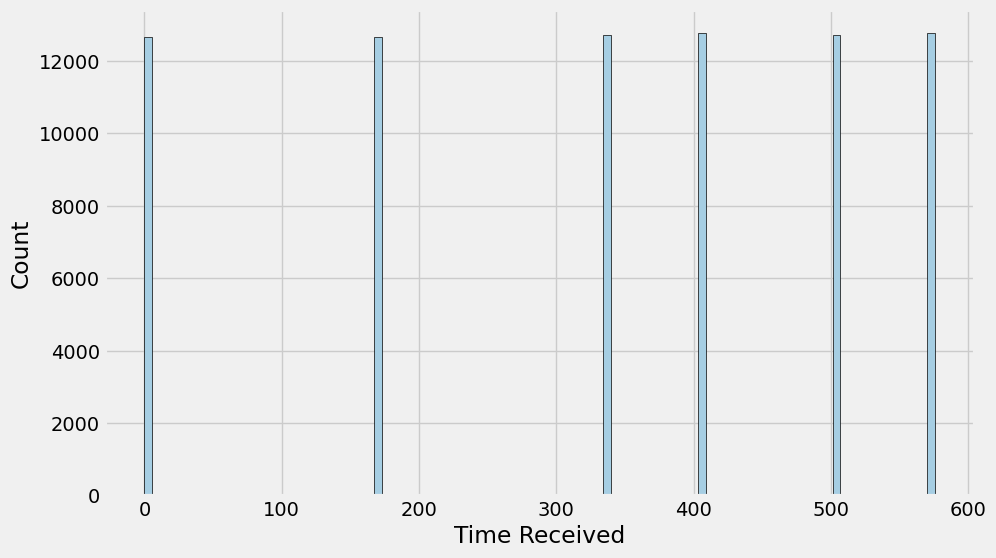

In [37]:
# visualize the offer send
plt.figure(figsize=(10,6))
plt.hist(offer_received["time"], bins=100, edgecolor='k')
plt.xlabel("Time Received")
plt.ylabel("Count")
plt.show()


In [38]:
# get offer send times
unique_times = offer_received["time"].unique()
print(sorted(unique_times))


[np.int64(0), np.int64(168), np.int64(336), np.int64(408), np.int64(504), np.int64(576)]


In [39]:
# get all customers, filter to "base" later
all_customers = set(actions["person"].unique())
len(all_customers)


17000

In [40]:
# define the whole of the population (minus the control)
received_at_168 = set(
    actions[
        (actions["event"] == "offer received") & (actions["time"] == 168)
    ]["person"]
)
len(received_at_168)

12669

In [41]:
# define the control
no_offer_at_168 = all_customers - received_at_168
len(no_offer_at_168)

4331

In [42]:
no_offer_df = pd.DataFrame(list(no_offer_at_168), columns=["person"])
no_offer_df

,person
0,9f0333c5f46c493580bbd3edd7aff58c
1,b1e18f93038f45c7ae46bd835ac8c9f0
2,8f26a78925e24c22a03dc134fb44fc4b
3,d04e831525064891a554847efa349fd8
4,e221d896cd5147768d19ea5bc3a53fe4
...,...
4326,32d4cf1c3c61452f99bfe9b193cc656a
4327,7fa4dff92dce46e1bf9bbc1fb7074a3d
4328,f952e2943933489faa4d7b269190e644
4329,494fdf36c8c0414ab6b2cb49c057b5a5


In [43]:
# population who made a purchase during 7 days following offer
purchase_next_week = set(actions[
    (actions["event"] == "transaction") &
    (actions["time"] > 168) & (actions["time"] <= 336)
]["person"])
len(purchase_next_week)

12753

In [44]:
# RECEIVED group: who made a purchase
purchased_received = set(purchase_next_week) & received_at_168

# NO OFFER group: who made a purchase
purchased_no_offer = set(purchase_next_week) & no_offer_at_168

print(f"Offer received group: {len(purchased_received)} made a purchase")
print(f"No offer group: {len(purchased_no_offer)} made a purchase")


Offer received group: 9927 made a purchase
No offer group: 2826 made a purchase


In [45]:
conversion_received = len(purchased_received) / len(received_at_168)
conversion_no_offer = len(purchased_no_offer) / len(no_offer_at_168)

print(f"Offer received group conversion: {conversion_received:.2%}")
print(f"No offer group conversion: {conversion_no_offer:.2%}")


Offer received group conversion: 78.36%
No offer group conversion: 65.25%


In [46]:
# treatment cohort — every event for the people who got the offer
df_treat = actions[actions["person"].isin(received_at_168)].copy()

# control cohort — every event for the people who didn’t
df_control = actions[actions["person"].isin(no_offer_at_168)].copy()
df_control

,Unnamed: 0,person,event,value,time,offer_id
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
6,6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2
11,11,3d02345581554e81b7b289ab5e288078,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
14,14,d53717f5400c4e84affdaeda9dd926b3,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...,...,...
306527,306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,None
306528,306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,None
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None


In [47]:
# double check the control group
control_check = (df_control["event"] == "offer received") & (df_control["time"] == 168)
df_control[control_check]

,Unnamed: 0,person,event,value,time,offer_id


In [48]:
# double check the treatment group
treat_check = (df_treat["event"] == "offer received") & (df_treat["time"] == 168)
df_treat[treat_check]

,Unnamed: 0,person,event,value,time,offer_id
53174,53174,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5
53175,53175,38fe809add3b4fcf9315a9694bb96ff5,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,9b98b8c7a33c4b65b9aebfe6a799e6d9
53176,53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
53177,53177,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168,4d5c57ea9a6940dd891ad53e9dbe8da0
53178,53178,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168,ae264e3637204a6fb9bb56bc8210ddfd
...,...,...,...,...,...,...
65838,65838,670626b55bfb4ba39c85b27cc7cca527,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
65839,65839,79edb810789c447e8d212a324b44cc16,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},168,3f207df678b143eea3cee63160fa8bed
65840,65840,f924927e7f844ecebf87eef93f4d2688,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5
65841,65841,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [49]:
# define time window
SNAPSHOT = 168
LOOKBACK = 168

In [50]:
# filter the raw log to the history window
hist = actions[
    (actions["event"] == "transaction") &
    (actions["time"] >= SNAPSHOT - LOOKBACK) &
    (actions["time"] <  SNAPSHOT)
]

# recency = hours since last txn (lower is fresher)
recency_df = (
    hist.groupby("person")["time"]
        .max()
        .rsub(SNAPSHOT)            # SNAPSHOT - last_txn_time
        .rename("recency")
)

# frequency = transactions in lookback window
freq_df = (
    hist.groupby("person")["time"]
        .size()
        .rename("frequency")
)

rf = (
    pd.concat([recency_df, freq_df], axis=1)
      .reindex(actions["person"].unique())   # include people w/ no history
      .fillna({"recency": SNAPSHOT, "frequency": 0})
      .reset_index()
)


In [51]:
rf.iloc[900:905]

,person,recency,frequency
900,d558b038136e4474a94ac2bb0a67efc9,6.0,2.0
901,cbecec5803434d63bce1e4c451d4b2d7,168.0,0.0
902,593c3cd7ab1e4a10a6f9279544da7df3,168.0,0.0
903,5ec47474a7244d7c8be5d44e99c39c35,168.0,0.0
904,15f68a59b74546f892bd9f277c9a42ae,24.0,9.0


In [52]:
# get treatment-labeled dataframe in order
labels = pd.DataFrame({
    "person": list(received_at_168 | no_offer_at_168),
})
labels["treatment"] = labels["person"].isin(received_at_168).astype(int)

# add recency & frequency
labels = labels.merge(rf, on="person", how="left")


In [53]:
labels

,person,treatment,recency,frequency
0,6d1ebb4a12294423ae8511092abe9db8,1,168.0,0.0
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0
2,0ff55591a7c54f74b0c125c9ba18590d,1,24.0,6.0
3,8f26a78925e24c22a03dc134fb44fc4b,0,168.0,0.0
4,f15b7751efdf45fe9c4a4e08fc474744,1,168.0,0.0
...,...,...,...,...
16995,bc3694dd6a25450ca80f4d4a60719236,1,168.0,0.0
16996,ff964fce42a74d519bd1ad2e0e20cd9e,1,84.0,1.0
16997,532571ad78ae4715960d27bf653d2308,1,138.0,1.0
16998,a043e5b2568541efbe9a1b7fa65b8c35,1,132.0,1.0


In [54]:
actions = actions.copy()
actions["offer_id"] = actions["value"].apply(
    lambda x: x.get("offer id") if isinstance(x, dict) else np.nan
)

In [55]:
actions = actions.merge(
    offers.rename(columns={"id": "offer_id"}),
    on="offer_id",
    how="left"
)


In [56]:
actions

,Unnamed: 0_x,person,event,value,time,offer_id,Unnamed: 0_y,reward,channels,difficulty,duration,offer_type
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,3.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4.0,5.0,"['web', 'email']",20.0,10.0,discount
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,9.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,6.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,10.0,"['web', 'email', 'mobile', 'social']",10.0,5.0,bogo
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,None,NaN,NaN,NaN,NaN,NaN,NaN
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# keep only the "base" customers
labels = labels.merge(
    base,    
    on="person",
    how="inner"
)
labels

,person,treatment,recency,frequency,Unnamed: 0,gender,age,income,join_date
0,6d1ebb4a12294423ae8511092abe9db8,1,168.0,0.0,6834,M,60,64000.0,20170729
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0,12985,M,58,40000.0,20180422
2,0ff55591a7c54f74b0c125c9ba18590d,1,24.0,6.0,13142,M,63,50000.0,20161213
3,f15b7751efdf45fe9c4a4e08fc474744,1,168.0,0.0,9379,F,51,97000.0,20171010
4,b857481919e44cf29b036eca3217d2da,1,48.0,3.0,5645,M,69,72000.0,20171030
...,...,...,...,...,...,...,...,...,...
14820,0e6943735578469cada541e3654a5693,0,24.0,2.0,1509,M,42,48000.0,20150901
14821,bc3694dd6a25450ca80f4d4a60719236,1,168.0,0.0,15951,M,47,38000.0,20150215
14822,532571ad78ae4715960d27bf653d2308,1,138.0,1.0,6609,M,40,50000.0,20170511
14823,a043e5b2568541efbe9a1b7fa65b8c35,1,132.0,1.0,1543,M,20,67000.0,20160814


In [58]:
# get metadata for offers (ended up not using)
treat_meta = (
    actions.loc[
        (actions["event"] == "offer received") & (actions["time"] == 168),
        ["person", "offer_type", "difficulty", "reward"]
    ]
    .drop_duplicates("person") 
)

labels = labels.merge(treat_meta, on="person", how="left")   # control rows → NaN

In [59]:
labels

,person,treatment,recency,frequency,Unnamed: 0,gender,age,income,join_date,offer_type,difficulty,reward
0,6d1ebb4a12294423ae8511092abe9db8,1,168.0,0.0,6834,M,60,64000.0,20170729,informational,0.0,0.0
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0,12985,M,58,40000.0,20180422,bogo,10.0,10.0
2,0ff55591a7c54f74b0c125c9ba18590d,1,24.0,6.0,13142,M,63,50000.0,20161213,informational,0.0,0.0
3,f15b7751efdf45fe9c4a4e08fc474744,1,168.0,0.0,9379,F,51,97000.0,20171010,discount,10.0,2.0
4,b857481919e44cf29b036eca3217d2da,1,48.0,3.0,5645,M,69,72000.0,20171030,informational,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14820,0e6943735578469cada541e3654a5693,0,24.0,2.0,1509,M,42,48000.0,20150901,NaN,NaN,NaN
14821,bc3694dd6a25450ca80f4d4a60719236,1,168.0,0.0,15951,M,47,38000.0,20150215,bogo,5.0,5.0
14822,532571ad78ae4715960d27bf653d2308,1,138.0,1.0,6609,M,40,50000.0,20170511,bogo,5.0,5.0
14823,a043e5b2568541efbe9a1b7fa65b8c35,1,132.0,1.0,1543,M,20,67000.0,20160814,discount,7.0,3.0


In [60]:
# purchase flag equals 1 if purchase made in next ten days
purchase_flag = (
    actions.loc[
        (actions["event"] == "transaction") &
        (actions["time"] > SNAPSHOT) &
        (actions["time"] <= SNAPSHOT + 240),
        ["person"]
    ]
    .assign(purchase_next_week=1)
    .drop_duplicates()
)

# merge everything
labels = (
    pd.DataFrame({"person": list(received_at_168 | no_offer_at_168)})
      .assign(treatment=lambda d: d["person"].isin(received_at_168).astype(int))
      .merge(rf, on="person", how="left")
      .merge(base, on="person", how="left")           # demographics
      .merge(purchase_flag, on="person", how="left")
      .fillna({"purchase_next_week": 0})
)

labels = (labels
          .merge(treat_meta, on="person", how="left")
          .fillna({"offer_type": "no_offer",
                   "difficulty": 0,
                   "reward": 0,
                   "duration": 0,
                   "channels": "none"}))

labels['treatment'].value_counts()

treatment
1    12669
0     4331
Name: count, dtype: int64

In [61]:
# clean up age and gender
labels = labels.dropna(subset=["age"])

labels = pd.get_dummies(labels, columns=['gender'], drop_first=True).drop(columns="gender_O")

labels

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
0,6d1ebb4a12294423ae8511092abe9db8,1,168.0,0.0,6834.0,60.0,64000.0,20170729.0,1.0,informational,0.0,0.0,True
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0,12985.0,58.0,40000.0,20180422.0,1.0,bogo,10.0,10.0,True
2,0ff55591a7c54f74b0c125c9ba18590d,1,24.0,6.0,13142.0,63.0,50000.0,20161213.0,1.0,informational,0.0,0.0,True
4,f15b7751efdf45fe9c4a4e08fc474744,1,168.0,0.0,9379.0,51.0,97000.0,20171010.0,1.0,discount,10.0,2.0,False
5,b857481919e44cf29b036eca3217d2da,1,48.0,3.0,5645.0,69.0,72000.0,20171030.0,1.0,informational,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16994,0e6943735578469cada541e3654a5693,0,24.0,2.0,1509.0,42.0,48000.0,20150901.0,1.0,no_offer,0.0,0.0,True
16995,bc3694dd6a25450ca80f4d4a60719236,1,168.0,0.0,15951.0,47.0,38000.0,20150215.0,1.0,bogo,5.0,5.0,True
16997,532571ad78ae4715960d27bf653d2308,1,138.0,1.0,6609.0,40.0,50000.0,20170511.0,1.0,bogo,5.0,5.0,True
16998,a043e5b2568541efbe9a1b7fa65b8c35,1,132.0,1.0,1543.0,20.0,67000.0,20160814.0,1.0,discount,7.0,3.0,True


In [62]:
ate = (labels.loc[labels["treatment"]==1, "purchase_next_week"].mean() -
       labels.loc[labels["treatment"]==0, "purchase_next_week"].mean())
print(f"Raw diff-in-means ATE: {ate:.3%}")


Raw diff-in-means ATE: 5.446%


In [63]:
# compare average recency/frequency in treatment vs control to be sure treatment is random
for col in ["recency", "frequency"]:
    mean_t = labels.loc[labels["treatment"]==1, col].mean()
    mean_c = labels.loc[labels["treatment"]==0, col].mean()
    print(f"{col}: Treatment mean = {mean_t:.2f}, Control mean = {mean_c:.2f}")


recency: Treatment mean = 97.34, Control mean = 98.72
frequency: Treatment mean = 1.58, Control mean = 1.54


In [64]:
#seperate offer types for analysis and modeling
bogo = labels.loc[labels["offer_type"] == "bogo"]
discount = labels.loc[labels["offer_type"] == "discount"]
informational = labels.loc[labels["offer_type"] == "informational"]
control = labels.loc[labels["offer_type"] == "no_offer"]
bogo = pd.concat([bogo, control])
discount = pd.concat([discount, control])
informational = pd.concat([informational, control])
bogo

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0,12985.0,58.0,40000.0,20180422.0,1.0,bogo,10.0,10.0,True
8,72d8321b934b4e09952001bcd87662a3,1,78.0,2.0,3172.0,39.0,42000.0,20171105.0,1.0,bogo,5.0,5.0,False
9,84dbb83b9c0d4e1f9e94e2a6ed901814,1,168.0,0.0,3539.0,74.0,61000.0,20180703.0,1.0,bogo,5.0,5.0,True
13,41432b5e320846288781470dcc1ce194,1,168.0,0.0,2706.0,49.0,90000.0,20161018.0,1.0,bogo,5.0,5.0,False
15,c997ff8618074ed9b5c1421ec762c4e7,1,126.0,3.0,11249.0,52.0,73000.0,20160727.0,1.0,bogo,10.0,10.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,d5b9c42225b447b799a4a8976f146425,0,6.0,2.0,12558.0,33.0,44000.0,20180517.0,1.0,no_offer,0.0,0.0,False
16986,041967ceb80841ddbd306958d4f744ac,0,60.0,1.0,6394.0,57.0,88000.0,20170616.0,1.0,no_offer,0.0,0.0,False
16991,8037cd9c2a4447d2a206f279877dcc7d,0,78.0,1.0,8590.0,73.0,91000.0,20151217.0,1.0,no_offer,0.0,0.0,False
16993,f5b6da50d5f044448c3de0590e9cab29,0,18.0,6.0,14852.0,86.0,70000.0,20160604.0,1.0,no_offer,0.0,0.0,False


In [65]:
control["frequency"].value_counts(normalize=True)

frequency
0.0     0.329171
1.0     0.276302
2.0     0.176142
3.0     0.097237
4.0     0.055260
5.0     0.027630
6.0     0.020988
7.0     0.009564
8.0     0.003188
9.0     0.002125
10.0    0.001063
12.0    0.000797
11.0    0.000531
Name: proportion, dtype: float64

In [66]:
control.head(20)

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M
6,187b3bf0d99f40c585166d98cadc941c,0,168.0,0.0,12149.0,63.0,88000.0,20150823.0,0.0,no_offer,0.0,0.0,False
19,078808d49ac341a0a303212f258a3410,0,168.0,0.0,5389.0,66.0,59000.0,20180423.0,1.0,no_offer,0.0,0.0,False
21,ce1579c557c14f7785869dc80638bc0f,0,168.0,0.0,3789.0,79.0,72000.0,20160524.0,0.0,no_offer,0.0,0.0,False
43,46bff6d3b8fb462880a0d476c3945c33,0,12.0,5.0,6628.0,68.0,48000.0,20171103.0,1.0,no_offer,0.0,0.0,False
46,8ba1268e963c48ddaebbe453bb9d3cb4,0,168.0,0.0,15254.0,50.0,75000.0,20151020.0,1.0,no_offer,0.0,0.0,False
49,f1b3e753d03245eabf1168451261e0f8,0,96.0,1.0,16688.0,65.0,117000.0,20161215.0,1.0,no_offer,0.0,0.0,False
50,330392fa98824cdebfcbdb514aa786dd,0,66.0,2.0,11701.0,68.0,34000.0,20180118.0,1.0,no_offer,0.0,0.0,True
53,09271091511549778c0979d64bf3dfac,0,12.0,2.0,1984.0,41.0,40000.0,20180626.0,1.0,no_offer,0.0,0.0,True
64,a3e9b21325054afe84824e4ff00fcaf0,0,168.0,0.0,8850.0,52.0,44000.0,20180106.0,1.0,no_offer,0.0,0.0,True
66,e3504fe85a1e4344be0987966279edfb,0,168.0,0.0,6306.0,63.0,36000.0,20170321.0,1.0,no_offer,0.0,0.0,False


In [67]:
# set up columns and targets for first UPLIFT MODEL
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = bogo[feature_cols]
y = bogo["purchase_next_week"]
w = bogo["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


In [68]:
# train and predict UPLIFT MODEL
uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)


In [69]:
# assign uplift predictions as %
bogo_preds = bogo.copy()
bogo_preds["preds"] = cate_preds
bogo_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
1,c014dcf29fb54b12a509e0fa0506520c,1,108.0,1.0,12985.0,58.0,40000.0,20180422.0,1.0,bogo,10.0,10.0,True,-0.000639
8,72d8321b934b4e09952001bcd87662a3,1,78.0,2.0,3172.0,39.0,42000.0,20171105.0,1.0,bogo,5.0,5.0,False,0.048236
9,84dbb83b9c0d4e1f9e94e2a6ed901814,1,168.0,0.0,3539.0,74.0,61000.0,20180703.0,1.0,bogo,5.0,5.0,True,0.030622
13,41432b5e320846288781470dcc1ce194,1,168.0,0.0,2706.0,49.0,90000.0,20161018.0,1.0,bogo,5.0,5.0,False,0.195432
15,c997ff8618074ed9b5c1421ec762c4e7,1,126.0,3.0,11249.0,52.0,73000.0,20160727.0,1.0,bogo,10.0,10.0,True,0.071785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,d5b9c42225b447b799a4a8976f146425,0,6.0,2.0,12558.0,33.0,44000.0,20180517.0,1.0,no_offer,0.0,0.0,False,0.104675
16986,041967ceb80841ddbd306958d4f744ac,0,60.0,1.0,6394.0,57.0,88000.0,20170616.0,1.0,no_offer,0.0,0.0,False,0.089054
16991,8037cd9c2a4447d2a206f279877dcc7d,0,78.0,1.0,8590.0,73.0,91000.0,20151217.0,1.0,no_offer,0.0,0.0,False,0.082465
16993,f5b6da50d5f044448c3de0590e9cab29,0,18.0,6.0,14852.0,86.0,70000.0,20160604.0,1.0,no_offer,0.0,0.0,False,0.047558


In [70]:
bogo_preds = bogo_preds.sort_values(by="preds", ascending=False)
bogo_preds.head(20)

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
14235,e4c1df33299b4b9d9d8924a45823095d,1,168.0,0.0,7489.0,61.0,113000.0,20161105.0,1.0,bogo,5.0,5.0,False,0.216260
3877,83050d3e8f1841469a596565018383f1,1,168.0,0.0,5341.0,62.0,120000.0,20170130.0,1.0,bogo,10.0,10.0,False,0.215982
9217,9f8b97dbbf3740199a0c701febb6a687,0,168.0,0.0,2023.0,53.0,100000.0,20170127.0,1.0,no_offer,0.0,0.0,False,0.215385
14829,40bc3cf593394618b90f6d79e198867a,0,168.0,0.0,3101.0,64.0,109000.0,20161112.0,0.0,no_offer,0.0,0.0,False,0.215301
2725,7d2f4592e232437d92e875ba21c03bc4,1,168.0,0.0,5691.0,59.0,98000.0,20161205.0,1.0,bogo,5.0,5.0,False,0.213277
2549,546267273d6041f48946369c65c11531,1,168.0,0.0,8911.0,62.0,103000.0,20161213.0,1.0,bogo,10.0,10.0,True,0.212901
988,2c38043147564d189ca3ae755b835851,0,168.0,0.0,8046.0,64.0,108000.0,20170218.0,1.0,no_offer,0.0,0.0,False,0.212192
10279,27dcaf139e2f42cc8325f09ea090cdf9,1,168.0,0.0,16528.0,54.0,107000.0,20170131.0,0.0,bogo,5.0,5.0,False,0.211695
15180,29655cba61a04d079efde18203b4f232,1,168.0,0.0,14281.0,67.0,101000.0,20161017.0,1.0,bogo,5.0,5.0,False,0.211674
16161,a187f250fe72405788e7fcf0c20b8e09,0,168.0,0.0,663.0,51.0,106000.0,20170323.0,1.0,no_offer,0.0,0.0,False,0.211389


In [71]:
# logistic regression model as PROPENSITY CHECK
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X  = bogo_preds[feature_cols]
w  = bogo_preds["treatment"]

prop_model = LogisticRegression(max_iter=500)
prop_model.fit(X[feature_cols], w)
p_scores = prop_model.predict_proba(X[feature_cols])[:, 1]

auc = roc_auc_score(w, p_scores)
print(f"Propensity-model AUC  (0.5=random,1.0=perfect):  {auc:.3f}")


Propensity-model AUC  (0.5=random,1.0=perfect):  0.512


In [72]:
# fit "explainer tree" to cate_preds
explainer_tree = DecisionTreeRegressor(max_depth=3)
explainer_tree.fit(X, cate_preds)

# print the decision rules
print(export_text(explainer_tree, feature_names=list(X.columns)))


|--- age <= 94.50
|   |--- income <= 39500.00
|   |   |--- join_date <= 20171029.00
|   |   |   |--- value: [0.07]
|   |   |--- join_date >  20171029.00
|   |   |   |--- value: [0.07]
|   |--- income >  39500.00
|   |   |--- frequency <= 2.50
|   |   |   |--- value: [0.07]
|   |   |--- frequency >  2.50
|   |   |   |--- value: [0.07]
|--- age >  94.50
|   |--- join_date <= 20160517.00
|   |   |--- recency <= 147.00
|   |   |   |--- value: [0.07]
|   |   |--- recency >  147.00
|   |   |   |--- value: [0.05]
|   |--- join_date >  20160517.00
|   |   |--- income <= 73500.00
|   |   |   |--- value: [0.08]
|   |   |--- income >  73500.00
|   |   |   |--- value: [0.12]



In [73]:
# feature importances
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")


recency                       : 0.1317
frequency                     : 0.0801
age                           : 0.1600
income                        : 0.1648
gender_M                      : 0.0381
join_date                     : 0.4252


In [74]:
# quick correlation check
labels[["age","income"]].corr()

# slice observed uplift by age quartile
labels["age_band"] = pd.qcut(labels["age"], 4)
observed_uplift = labels.groupby("age_band").apply(
    lambda g: g[g.treatment==1].purchase_next_week.mean() -
              g[g.treatment==0].purchase_next_week.mean())
print(observed_uplift)


age_band
(17.999, 42.0]    0.060428
(42.0, 55.0]      0.060145
(55.0, 66.0]      0.049932
(66.0, 101.0]     0.047878
dtype: float64


/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6860/2577982553.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_uplift = labels.groupby("age_band").apply(
/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_6860/2577982553.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  observed_uplift = labels.groupby("age_band").apply(


In [75]:
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = discount[feature_cols]
y = discount["purchase_next_week"]
w = discount["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)




In [76]:
discount_preds = discount.copy()
discount_preds["preds"] = cate_preds
discount_preds = discount_preds.sort_values(by="preds", ascending=False)


In [77]:
discount_preds.iloc[100:126]

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
10853,8c764c8fef2e43c8a7d7f1a1a97f1760,0,168.0,0.0,8855.0,62.0,85000.0,20160507.0,0.0,no_offer,0.0,0.0,True,0.200861
3286,95ef73ccde5740e5ba055c9ff322ae68,1,168.0,0.0,9696.0,67.0,108000.0,20160601.0,1.0,discount,10.0,2.0,True,0.200858
10432,7ea7b6c717e045b8b82a28a7f96957fe,0,168.0,0.0,9824.0,70.0,116000.0,20160207.0,1.0,no_offer,0.0,0.0,True,0.200847
9217,9f8b97dbbf3740199a0c701febb6a687,0,168.0,0.0,2023.0,53.0,100000.0,20170127.0,1.0,no_offer,0.0,0.0,False,0.200826
6421,dafc626bbdac41a8ae6b4f7a9478b2b2,0,168.0,0.0,6579.0,67.0,103000.0,20160306.0,1.0,no_offer,0.0,0.0,False,0.200825
15072,98da9b1c61c447bb806a7d259a715472,1,168.0,0.0,12649.0,92.0,106000.0,20160929.0,1.0,discount,10.0,2.0,True,0.200793
600,49ae517b9f4c4ee1a07418b28ea549c2,1,168.0,0.0,7682.0,66.0,96000.0,20170424.0,0.0,discount,20.0,5.0,False,0.200771
14757,8aa7a381391c4ef9a7d3c0e2edfdd3e9,1,168.0,0.0,10503.0,66.0,98000.0,20160410.0,1.0,discount,7.0,3.0,False,0.200760
4894,229191ca2b9d4620bd61677fd7f328c4,0,168.0,0.0,9762.0,69.0,108000.0,20160427.0,1.0,no_offer,0.0,0.0,True,0.200707
7185,c63d0ac9e9eb4bfe8e4d043d71890729,0,168.0,0.0,15148.0,91.0,88000.0,20160805.0,1.0,no_offer,0.0,0.0,False,0.200556


In [78]:
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")

recency                       : 0.0942
frequency                     : 0.0847
age                           : 0.1558
income                        : 0.1052
gender_M                      : 0.0334
join_date                     : 0.5268


In [79]:
feature_cols = ["recency", "frequency", "age", "income", "gender_M", "join_date"]

X = informational[feature_cols]
y = informational["purchase_next_week"]
w = informational["treatment"]
w = w.replace({0: 'control', 1: 'treatment'})


uplift_rf = UpliftRandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=200,
    evaluationFunction='KL',
    control_name="control"  # <- NOT optional
)

uplift_rf.fit(X.values, treatment=w.values, y=y.values)

cate_preds = uplift_rf.predict(X.values)



In [80]:
informational_preds = informational.copy()
informational_preds["preds"] = cate_preds
informational_preds = informational_preds.sort_values(by="preds", ascending=False)
informational_preds.iloc[-20:]


,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
11381,e8eef0c431cc4fa98381ed2043c843a4,0,168.0,0.0,10519.0,48.0,91000.0,20180625.0,1.0,no_offer,0.0,0.0,True,-0.104888
12701,a4ecd1ebb16a4800bdbf57aaf0144078,0,168.0,0.0,4468.0,43.0,93000.0,20180711.0,0.0,no_offer,0.0,0.0,True,-0.104910
9397,b5416c7b6cc0409eb428aa6f098b4480,1,168.0,0.0,4638.0,39.0,66000.0,20180714.0,0.0,informational,0.0,0.0,True,-0.105277
15201,482ad6ac48684fd89647d11e02223dc0,0,168.0,0.0,11356.0,44.0,71000.0,20180529.0,1.0,no_offer,0.0,0.0,True,-0.105908
4201,46f60f79a7ad46b4ac99d4dfe250814c,0,168.0,0.0,14203.0,52.0,70000.0,20180630.0,1.0,no_offer,0.0,0.0,True,-0.106373
6262,6d2dd677fd624c6aadfa5be303242c6e,1,168.0,0.0,3935.0,53.0,108000.0,20180608.0,0.0,informational,0.0,0.0,False,-0.107076
8186,e50382fc3e704263897267f8bec8aacf,0,168.0,0.0,11527.0,40.0,61000.0,20180603.0,1.0,no_offer,0.0,0.0,False,-0.107210
8579,080fc5e11b2a4dbeb88e1ffa952cb638,0,168.0,0.0,9210.0,43.0,77000.0,20180711.0,1.0,no_offer,0.0,0.0,True,-0.109475
6720,4fe634565ad74b97b8b1412ca69914d6,0,168.0,0.0,4919.0,49.0,73000.0,20180527.0,1.0,no_offer,0.0,0.0,False,-0.109813
10778,320dd0b116d4427487c7d828e4b3e1be,0,168.0,0.0,4760.0,53.0,98000.0,20180715.0,1.0,no_offer,0.0,0.0,False,-0.110998


In [81]:
for col, imp in zip(X.columns, uplift_rf.feature_importances_):
    print(f"{col:<30}: {imp:.4f}")

recency                       : 0.1700
frequency                     : 0.0755
age                           : 0.1965
income                        : 0.1821
gender_M                      : 0.0403
join_date                     : 0.3356


In [82]:
informational_preds["preds"].min()

np.float64(-0.12270647120433242)

In [83]:
bogo_preds[bogo_preds["preds"] < bogo_preds["preds"].quantile(.01)]

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds
2857,6e71b66784844d1ab8376ac8ab096d4b,1,162.0,1.0,16971.0,52.0,75000.0,20180522.0,1.0,bogo,5.0,5.0,False,-0.011867
12466,7864a58fc3da452ab7ec1b5cd230ee15,0,168.0,0.0,10061.0,49.0,91000.0,20180518.0,0.0,no_offer,0.0,0.0,False,-0.011902
14534,60b7692b124f4de99279cf046d036092,1,168.0,0.0,2480.0,63.0,101000.0,20180625.0,1.0,bogo,10.0,10.0,True,-0.012119
1654,c0d210398dee4a0895b24444a5fcd1d2,0,102.0,1.0,42.0,45.0,33000.0,20180707.0,1.0,no_offer,0.0,0.0,True,-0.012357
14361,def155cf2d4944ce931bc304425f4660,0,132.0,1.0,15075.0,52.0,34000.0,20180609.0,1.0,no_offer,0.0,0.0,True,-0.012499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,fc546aaa32694c5cadfc43b97b563434,1,168.0,0.0,3571.0,59.0,87000.0,20180610.0,0.0,bogo,5.0,5.0,True,-0.034750
8080,c1d6f806a92c46fdaacaca6b9c8d2e18,0,138.0,1.0,12348.0,46.0,78000.0,20180531.0,1.0,no_offer,0.0,0.0,True,-0.036065
10731,5cc737397b384d559a097db907980242,1,168.0,0.0,8964.0,49.0,83000.0,20180613.0,1.0,bogo,10.0,10.0,True,-0.036895
14295,7e567d349dee4ca6a85805cff8b65c35,1,168.0,0.0,3305.0,49.0,81000.0,20180721.0,1.0,bogo,5.0,5.0,True,-0.037391


In [84]:
informational_preds["purchase_next_week"].value_counts()

purchase_next_week
1.0    5024
0.0     948
Name: count, dtype: int64

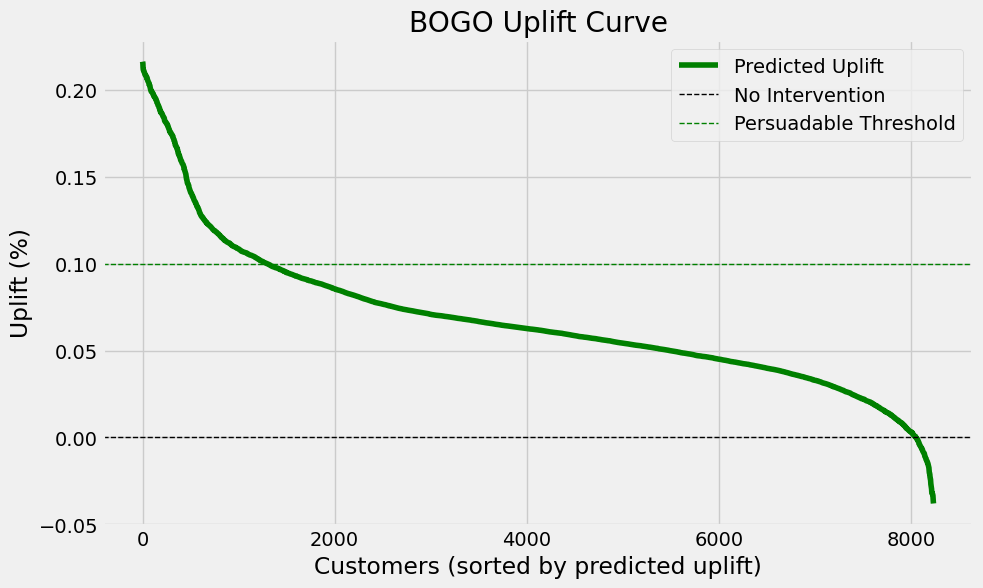

In [85]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called uplift_df with a column 'uplift'
# and it's already sorted from lowest to highest uplift

plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(bogo_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('BOGO Uplift Curve')
plt.legend()

plt.show()


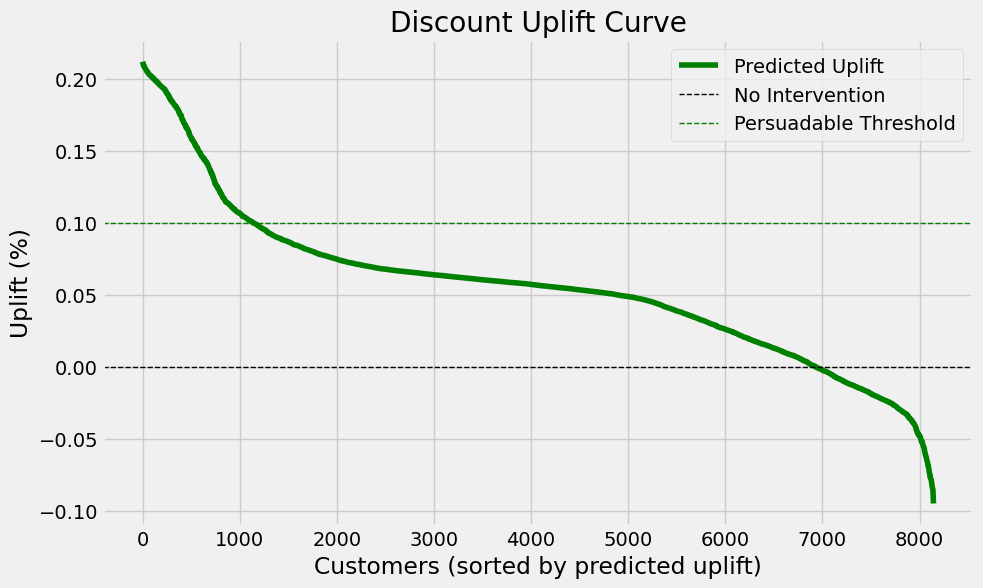

In [86]:
# Assuming you have a DataFrame called uplift_df with a column 'uplift'
# and it's already sorted from lowest to highest uplift

plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(discount_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('Discount Uplift Curve')
plt.legend()

plt.show()

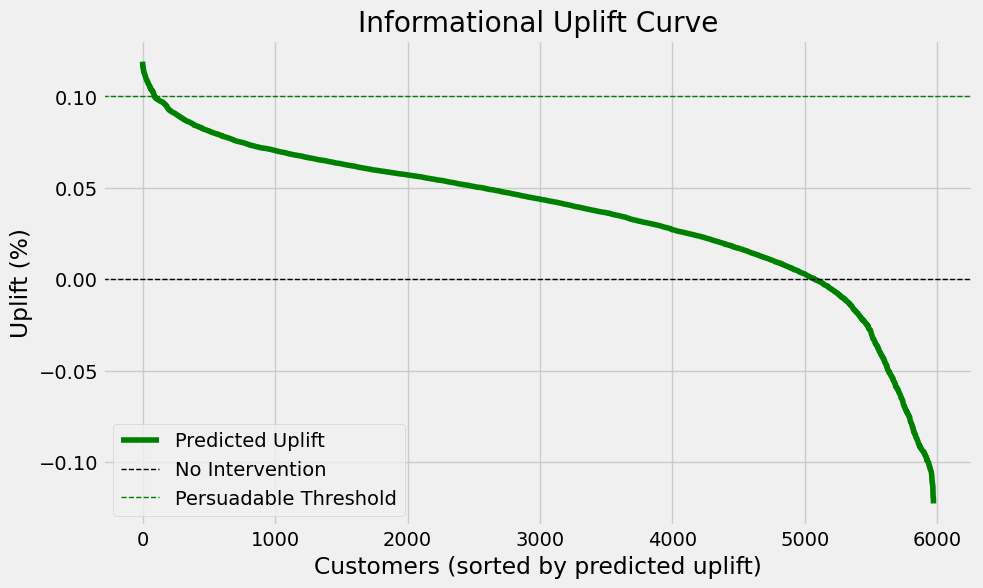

In [87]:
plt.figure(figsize=(10, 6))

# Plot uplift as a line (or points if you prefer)
plt.plot(informational_preds['preds'].values, color='green', label='Predicted Uplift')

# Add the zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='No Intervention')
plt.axhline(.1, color='green', linestyle='--', linewidth=1, label='Persuadable Threshold')

# Labels and title
plt.xlabel('Customers (sorted by predicted uplift)')
plt.ylabel('Uplift (%)')
plt.title('Informational Uplift Curve')
plt.legend()

plt.show()

In [88]:
# set thresholds
def categorize(row):
    if row['preds'] > 0.10:
        return 'Persuadable'
    elif row['preds'] < -0.05:
        return 'Do Not Disturb'
    else:
        return 'Sure Thing/Lost Cause'

bogo_preds['category'] = bogo_preds.apply(categorize, axis=1)
bogo_preds


,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
14235,e4c1df33299b4b9d9d8924a45823095d,1,168.0,0.0,7489.0,61.0,113000.0,20161105.0,1.0,bogo,5.0,5.0,False,0.216260,Persuadable
3877,83050d3e8f1841469a596565018383f1,1,168.0,0.0,5341.0,62.0,120000.0,20170130.0,1.0,bogo,10.0,10.0,False,0.215982,Persuadable
9217,9f8b97dbbf3740199a0c701febb6a687,0,168.0,0.0,2023.0,53.0,100000.0,20170127.0,1.0,no_offer,0.0,0.0,False,0.215385,Persuadable
14829,40bc3cf593394618b90f6d79e198867a,0,168.0,0.0,3101.0,64.0,109000.0,20161112.0,0.0,no_offer,0.0,0.0,False,0.215301,Persuadable
2725,7d2f4592e232437d92e875ba21c03bc4,1,168.0,0.0,5691.0,59.0,98000.0,20161205.0,1.0,bogo,5.0,5.0,False,0.213277,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,fc546aaa32694c5cadfc43b97b563434,1,168.0,0.0,3571.0,59.0,87000.0,20180610.0,0.0,bogo,5.0,5.0,True,-0.034750,Sure Thing/Lost Cause
8080,c1d6f806a92c46fdaacaca6b9c8d2e18,0,138.0,1.0,12348.0,46.0,78000.0,20180531.0,1.0,no_offer,0.0,0.0,True,-0.036065,Sure Thing/Lost Cause
10731,5cc737397b384d559a097db907980242,1,168.0,0.0,8964.0,49.0,83000.0,20180613.0,1.0,bogo,10.0,10.0,True,-0.036895,Sure Thing/Lost Cause
14295,7e567d349dee4ca6a85805cff8b65c35,1,168.0,0.0,3305.0,49.0,81000.0,20180721.0,1.0,bogo,5.0,5.0,True,-0.037391,Sure Thing/Lost Cause


In [89]:
bogo_preds["category"].value_counts()

category
Sure Thing/Lost Cause    6937
Persuadable              1299
Name: count, dtype: int64

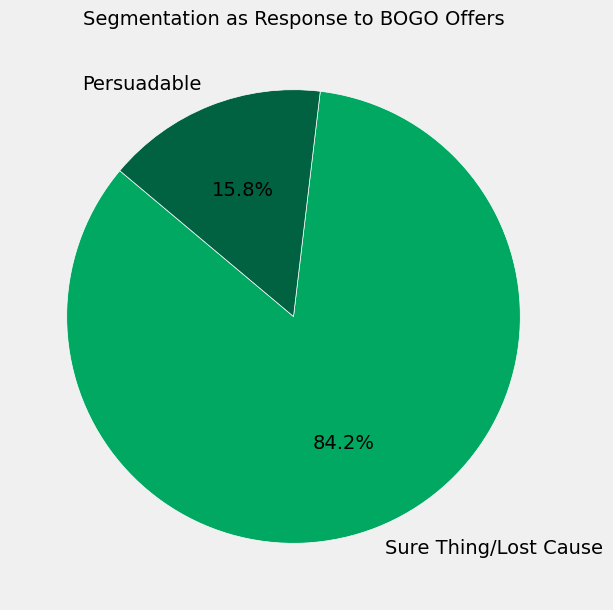

In [90]:
import matplotlib.pyplot as plt

# data
sizes = bogo_preds['category'].value_counts().values
labels = bogo_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#006241', '#B6D7B9']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})

plt.title('Segmentation as Response to BOGO Offers', fontsize=14)
plt.show()


In [91]:
discount_preds['category'] = discount_preds.apply(categorize, axis=1)
discount_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
8504,496ac7798e9d49e68468823dad0f43df,0,168.0,0.0,1897.0,86.0,90000.0,20160528.0,1.0,no_offer,0.0,0.0,True,0.211936,Persuadable
9369,55f752ed98374cc8bc85126766e66236,1,168.0,0.0,15730.0,63.0,104000.0,20160328.0,1.0,discount,20.0,5.0,True,0.211679,Persuadable
12770,17b2c631360648afa044912d9959615f,1,168.0,0.0,15606.0,75.0,98000.0,20170120.0,1.0,discount,7.0,3.0,True,0.211462,Persuadable
1272,f6c824b675514f3faafa162df87a1f71,0,168.0,0.0,15365.0,62.0,90000.0,20170202.0,1.0,no_offer,0.0,0.0,True,0.211058,Persuadable
8294,4eff60b798854f09924ef683d0479f89,0,168.0,0.0,7990.0,82.0,102000.0,20170204.0,0.0,no_offer,0.0,0.0,True,0.210978,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,461c8478728a47969f3b97b406b274cc,1,168.0,0.0,2745.0,49.0,114000.0,20180514.0,0.0,discount,20.0,5.0,True,-0.087569,Do Not Disturb
8915,34ae07af2aaf458aaf4763c0c658a20a,1,168.0,0.0,2591.0,56.0,92000.0,20180416.0,0.0,discount,7.0,3.0,True,-0.089777,Do Not Disturb
4391,839649618a584369a51d594acbd1e80d,1,168.0,0.0,12758.0,62.0,116000.0,20180419.0,0.0,discount,10.0,2.0,True,-0.089833,Do Not Disturb
14539,c765dc1f59bb44c1b80bef39a34ceeaa,1,168.0,0.0,6030.0,61.0,92000.0,20180617.0,0.0,discount,10.0,2.0,True,-0.093179,Do Not Disturb


In [92]:
discount_preds['category'].value_counts()

category
Sure Thing/Lost Cause    6871
Persuadable              1143
Do Not Disturb            131
Name: count, dtype: int64

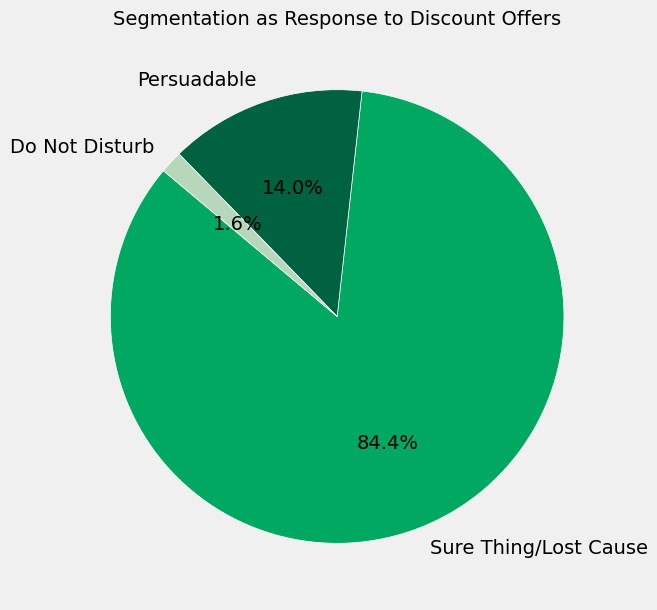

In [93]:
# data
sizes = discount_preds['category'].value_counts().values
labels = discount_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#006241', '#B6D7B9']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})

plt.title('Segmentation as Response to Discount Offers', fontsize=14)
plt.show()

In [94]:
informational_preds['category'] = informational_preds.apply(categorize, axis=1)
informational_preds

,person,treatment,recency,frequency,Unnamed: 0,age,income,join_date,purchase_next_week,offer_type,difficulty,reward,gender_M,preds,category
14064,e27b7b5d901d438ab0365f39d460dbf5,1,168.0,0.0,7418.0,58.0,114000.0,20171214.0,1.0,informational,0.0,0.0,False,0.118969,Persuadable
1503,4a07eb5a13f44caaa15c867b65df2be7,0,168.0,0.0,11512.0,59.0,114000.0,20180120.0,1.0,no_offer,0.0,0.0,False,0.117448,Persuadable
12645,3769424ea9c84d198882174e8759614d,0,168.0,0.0,10698.0,18.0,68000.0,20180311.0,1.0,no_offer,0.0,0.0,False,0.116054,Persuadable
8463,5b36a2e916bd41ed8e708384df094e77,0,168.0,0.0,10308.0,48.0,118000.0,20170720.0,0.0,no_offer,0.0,0.0,False,0.116007,Persuadable
10669,75b430097f4c409a8236d49ddfe5117b,0,168.0,0.0,14880.0,55.0,87000.0,20171216.0,0.0,no_offer,0.0,0.0,False,0.115778,Persuadable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15882,2f4dbdcbd3b6442bbb0cbed5f935abd5,1,168.0,0.0,16106.0,52.0,76000.0,20180722.0,0.0,informational,0.0,0.0,False,-0.118306,Do Not Disturb
888,fb75504a0e404549995a3e8427a2a252,0,168.0,0.0,8152.0,48.0,64000.0,20180726.0,1.0,no_offer,0.0,0.0,False,-0.119140,Do Not Disturb
3742,6cbc092fb84a437f9a248420129ca1f2,0,168.0,0.0,6456.0,50.0,63000.0,20180616.0,1.0,no_offer,0.0,0.0,False,-0.119306,Do Not Disturb
914,42f00b6b150e45149c50db9bd642bca6,0,168.0,0.0,13249.0,45.0,70000.0,20180726.0,0.0,no_offer,0.0,0.0,False,-0.119401,Do Not Disturb


In [95]:
informational_preds["category"].value_counts()

category
Sure Thing/Lost Cause    5538
Do Not Disturb            343
Persuadable                91
Name: count, dtype: int64

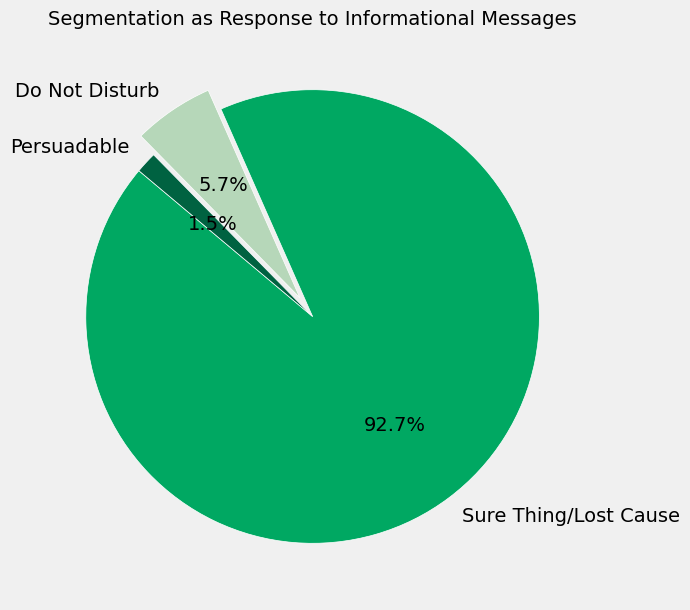

In [96]:
# data
sizes = informational_preds['category'].value_counts().values
labels = informational_preds['category'].value_counts().index

# starbucks-inspired colors
colors = ['#00A862', '#B6D7B9', '#006241']
explode = [0.1 if label == 'Do Not Disturb' else 0 for label in labels]

# pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode, wedgeprops={'edgecolor': 'white'})


plt.title('Segmentation as Response to Informational Messages', fontsize=14)
plt.show()